In [1]:
!pip install --no-cache-dir imageio

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print(tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import datetime

from IPython import display

2.1.0


In [125]:
BATCH_SIZE = 64

IMG_HEIGHT = 256
IMG_WIDTH = 256
noise_dim = 100
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def augment(img):
    img = tf.image.random_crop(img, [IMG_WIDTH, IMG_HEIGHT, 1])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return img

def process_path(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)*2-1
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH*2, IMG_HEIGHT*2])

def show_images(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(next(image_batch)[:,:,0], cmap='gray', vmin=-1, vmax=1)
      #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

def show_batch(image_batch):
  imgs = next(image_batch)
  plt.figure(figsize=(15,15))
  for n in range(64):
      ax = plt.subplot(8,8,n+1)
      plt.imshow(imgs[n,:,:,0], cmap='gray', vmin=-1, vmax=1)
      #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

raw = tf.data.Dataset.list_files('/tf/DATA/11/*/*/height_gs.png')
size = len(list(raw))
print(size, 'tiles')

train_dataset = raw.map(process_path, num_parallel_calls=4).cache().shuffle(size).map(augment, num_parallel_calls=4).batch(BATCH_SIZE).prefetch(2) 

3575 tiles


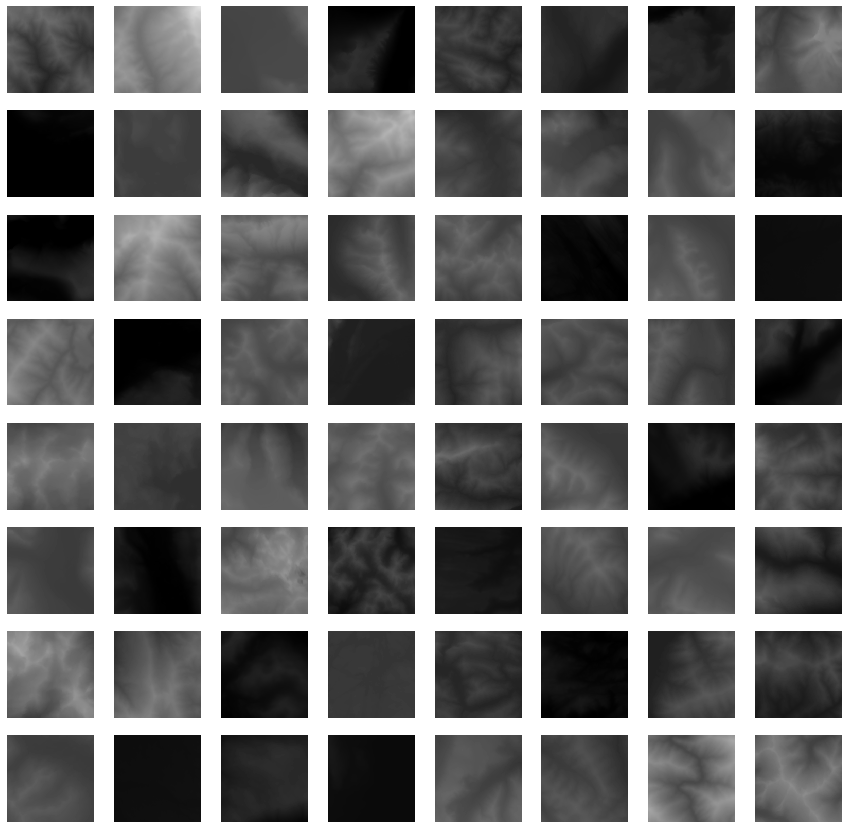

In [126]:
show_batch(train_dataset.take(1).as_numpy_iterator())

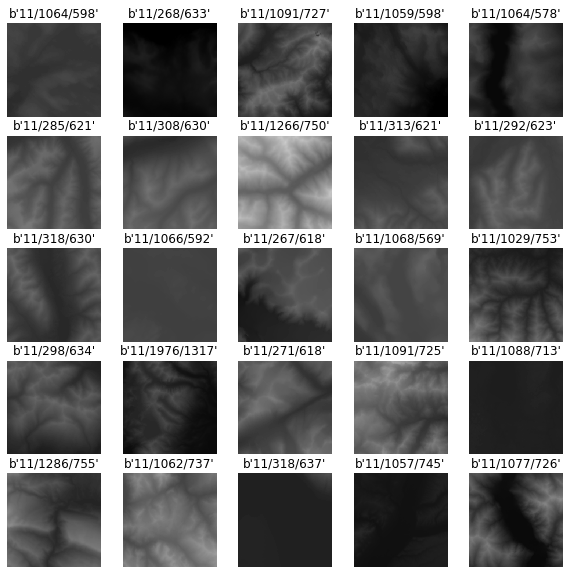

In [127]:
def process_path_labeled(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]), file_path

def show_batch_labeled(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n][:,:,0], cmap='gray', vmin=0, vmax=1)
      #plt.imshow(image_batch[n])
      plt.title(label_batch[n][9:-14])
      plt.axis('off')

debug_ds = raw.map(process_path_labeled, num_parallel_calls=4).batch(25)
image_batch, label_batch = next(iter(debug_ds))
show_batch_labeled(image_batch.numpy(), label_batch.numpy())

In [138]:
'''
def gan_g_layer(model, nFilter):
    model.add(layers.Conv2DTranspose(nFilter, (4,4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.ReLU())

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.ReLU()) 
    model.add(layers.Reshape((4, 4, 512)))
    
    gan_g_layer(model, 256)
    gan_g_layer(model, 128)
    gan_g_layer(model, 64)
    gan_g_layer(model, 32)

    model.add(layers.Conv2DTranspose(1, (4,4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMG_WIDTH, IMG_HEIGHT, 1) # Note: None is the batch size

    return model
'''
def gan_g_layer(model, nFilter, resizeConv=False):
    if resizeConv:
        model.add(layers.UpSampling2D(size=(2, 2), interpolation='bilinear'))
        model.add(layers.Conv2D(nFilter, (5, 5), strides=(1, 1), padding='same'))
    else:
        model.add(layers.Conv2DTranspose(nFilter, (4,4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())   

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) 
    model.add(layers.Reshape((4, 4, 512)))
    
    gan_g_layer(model, 512)
    gan_g_layer(model, 256)
    gan_g_layer(model, 256)
    gan_g_layer(model, 128)
    gan_g_layer(model, 128)
    gan_g_layer(model, 64)

    model.add(layers.Conv2D(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMG_WIDTH, IMG_HEIGHT, 1) # Note: None is the batch size

    return model

In [139]:
def gan_d_layer(model, nFilter):
    model.add(layers.Conv2D(nFilter, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_WIDTH, IMG_HEIGHT, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    gan_d_layer(model, 64)
    gan_d_layer(model, 128)
    gan_d_layer(model, 256)
    gan_d_layer(model, 512)
    gan_d_layer(model, 512)

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [140]:
G_LR = 1e-3
D_LR = 1e-4

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) #from_logits=True when removing sigmoid on D output layer

g_loss = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
d_real_loss = tf.keras.metrics.Mean('disc_real_loss', dtype=tf.float32)
d_fake_loss = tf.keras.metrics.Mean('disc_fake_loss', dtype=tf.float32)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    d_real_loss(real_loss)
    d_fake_loss(fake_loss)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    g_loss(loss)
    return loss

generator_optimizer = tf.keras.optimizers.Adam(G_LR)
discriminator_optimizer = tf.keras.optimizers.Adam(D_LR)

In [141]:
generator = make_generator_model()
discriminator = make_discriminator_model()

generator.summary()
discriminator.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 8192)              819200    
_________________________________________________________________
batch_normalization_150 (Bat (None, 8192)              32768     
_________________________________________________________________
re_lu_90 (ReLU)              (None, 8192)              0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 512)         4194304   
_________________________________________________________________
batch_normalization_151 (Bat (None, 8, 8, 512)         2048      
_________________________________________________________________
re_lu_91 (ReLU)              (None, 8, 8, 512)       

In [142]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [143]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [144]:
def generate_and_save_images(model, epoch, test_input, run_id):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(15,15))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.imshow(predictions[i, :, :, 0], cmap='gray', vmin=-1, vmax=1)
      plt.axis('off')

  plt.savefig(run_id+'/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [145]:
def train(dataset, start, epochs, run_id):
  generator.save('./'+run_id+'/generator/')
  discriminator.save('./'+run_id+'/discriminator/')
  checkpoint_prefix = os.path.join('./'+run_id+'/training_checkpoints', "ckpt")
  summary_writer = tf.summary.create_file_writer("logs/fit/" + run_id)
  with summary_writer.as_default():
    tf.summary.text('G_LR', str(G_LR), step=0)
    tf.summary.text('D_LR', str(D_LR), step=0)
  
  for epoch in range(start, start+epochs):
    start = time.time()
    
    for image_batch in dataset:
        # (gen_loss, disc_loss) = 
        train_step(image_batch)
        #i=i+1
        #with summary_writer.as_default():
        #    tf.summary.scalar('gen_loss', gen_loss, step=i)
        #    tf.summary.scalar('disc_loss', disc_loss, step=i)

    with summary_writer.as_default():
        tf.summary.scalar('gen_loss', g_loss.result(), step=epoch)
        tf.summary.scalar('disc_real_loss', d_real_loss.result(), step=epoch)
        tf.summary.scalar('disc_fake_loss', d_fake_loss.result(), step=epoch)
    
    g_loss.reset_states()
    d_real_loss.reset_states()
    d_fake_loss.reset_states()
    
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed, run_id)

    # Save the model every 25 epochs
    if (epoch + 1) % 25 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed, run_id)

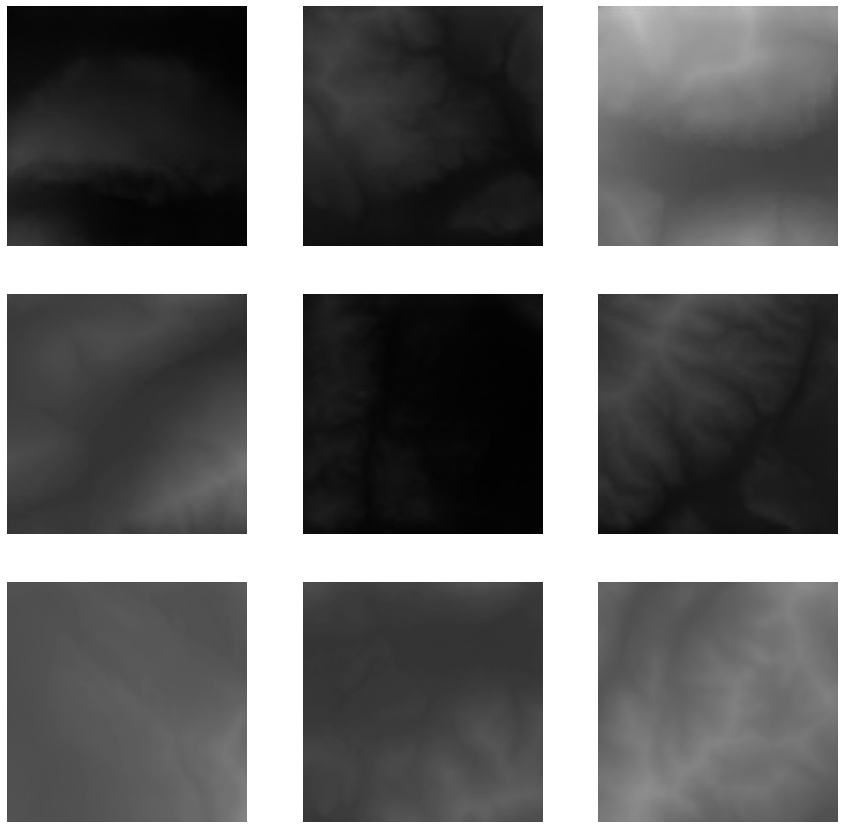

Time for epoch 1543 is 38.08948636054993 sec


In [ ]:
#RUN

EPOCHS = 2000
START = 0

run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(run_id)

with open(run_id + '/summary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    generator.summary(print_fn=lambda x: fh.write(x + '\n'))
    fh.write('\n')
    discriminator.summary(print_fn=lambda x: fh.write(x + '\n'))

train(train_dataset, START, EPOCHS, run_id)

In [147]:
anim_file = run_id+'/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(run_id+'/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    #else:
      #continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

Lossy conversion from float32 to uint8. Range [18.822792053222656, 99.46268463134766]. Convert image to uint8 prior to saving to suppress this warning.


tf.Tensor([[0.8677491]], shape=(1, 1), dtype=float32)


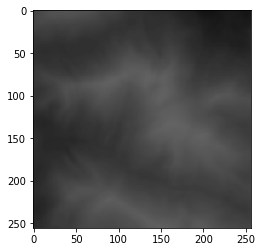

In [150]:
run_id = '20200312-095912'
g = tf.keras.models.load_model('./'+run_id+'/generator/')
d = tf.keras.models.load_model('./'+run_id+'/discriminator/')

cp = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=g,
                                 discriminator=d)

checkpoint_dir = './'+run_id+'/training_checkpoints'
cp.restore(tf.train.latest_checkpoint(checkpoint_dir))

noise = tf.random.normal([1, 100])
generated_image = g(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray', vmin=-1, vmax=1)
imageio.imwrite('./'+run_id+'/sample.png', generated_image[0, :, :, 0]*127.5+127.5)
decision = d(generated_image)
print (decision)

tf.Tensor([[0.09042314]], shape=(1, 1), dtype=float32)


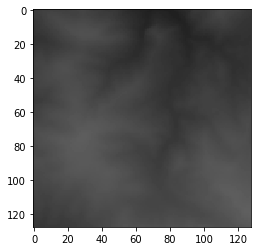

In [115]:
text_imgs = next(train_dataset.take(1).as_numpy_iterator())[:1]

plt.imshow(text_imgs[0, :, :, 0], cmap='gray', vmin=-1, vmax=1)

decision = d(text_imgs)
print (decision)